In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pygrib
from pyproj import Transformer
from glob import glob
import geopandas as gpd

<AxesSubplot:xlabel='TIMI'>

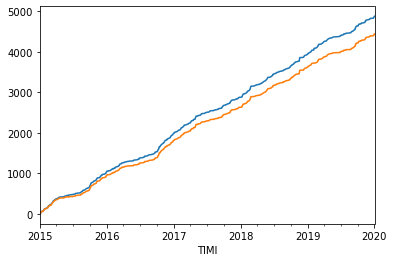

In [3]:
# rain_gauge data
GD_dirname = '../Experiments'
good_sensors = ['1475','1473','1481']
df_gauge = pd.read_pickle(f'{GD_dirname}/Data/rain_gauges_combined.pkl')    
raw_columns = [col for col in df_gauge.columns if 'raw' in col]
df_gauge.loc[:,raw_columns] = df_gauge.loc[:,raw_columns]
df_gauge = df_gauge.loc[:,[i for i in df_gauge.columns if any([ID in i for ID in good_sensors])]]

d_start = datetime.datetime(2015,1,1)
d_end = datetime.datetime(2020,1,1)
# d_end = datetime.datetime(2021,1,1)
df_gauge.loc[d_start:d_end,'1475_R_raw'].cumsum().plot()
df_gauge.loc[d_start:d_end,'1475_R_manual'].cumsum().plot()

In [4]:
df_gauge

STOD,1473_R_manual,1475_R_manual,1473_R_raw,1475_R_raw,1481_R_raw
TIMI,,,,,
2015-01-01 00:00:00,0.0,0.0,0.0,0.1,0.0
2015-01-01 01:00:00,0.5,0.3,0.5,0.3,0.0
2015-01-01 02:00:00,0.2,1.0,0.2,1.0,0.4
2015-01-01 03:00:00,0.4,1.0,0.4,1.0,0.0
2015-01-01 04:00:00,0.3,0.2,0.3,0.2,0.1
...,...,...,...,...,...
2020-12-31 19:00:00,0.0,0.0,0.0,0.0,0.0
2020-12-31 20:00:00,0.0,0.0,0.0,0.1,0.0
2020-12-31 21:00:00,0.0,0.0,0.0,0.0,0.0


In [4]:
nwp_data = pd.read_pickle('../Experiments/data/df_NWP.pkl')
nwp_data.loc[d_start:d_end].copy()
nwp_data[nwp_data < 0] = 0

In [9]:

tmp_filename = np.load('F:/harmony processed\\201511_urls.npy',allow_pickle=True)[0][40]
transformer_gps_isl = Transformer.from_crs("epsg:4326", "epsg:3057" ) # Umbreyta GPS staðsetningu yfir í cartesian hnit fyrir Ísland
transformer_isl_gps = Transformer.from_crs("epsg:3057", "epsg:4326") # Umbreyta cartesian hnitum aftur í GPS hnit

lons = pygrib.open(tmp_filename).read()[0].longitudes - 360
lats = pygrib.open(tmp_filename).read()[0].latitudes
values = pygrib.open(tmp_filename).read()[0].values
coords = np.array([transformer_gps_isl.transform(b,a) for a,b in zip(lons,lats)])
xr,yr = values.shape

# For visualization

In [10]:
postnr = gpd.read_file('../Radar data analysis/Radar visualization/Shapefiles/postnr/postnrs.shp')

transformer_gps_isl = Transformer.from_crs("epsg:4326", "epsg:3057" ) # Umbreyta GPS staðsetningu yfir í cartesian hnit fyrir Ísland
transformer_isl_gps = Transformer.from_crs("epsg:3057", "epsg:4326") # Umbreyta cartesian hnitum aftur í GPS hnit

sitecoords = (-22.636, 64.025, 45.0)
radar_x,radar_y = transformer_gps_isl.transform(sitecoords[1],sitecoords[0])
gauge_x,gauge_y = transformer_gps_isl.transform(64.1275,-21.902)

# Get information about the gauges of interest

In [11]:
URL_gauge_data = 'C:/Users/sverrirhd/Google Drive/Skóli/DTU/Thesis/Data/Rain gauges/'
df_meta_gauge = np.load(URL_gauge_data + 'sensor_info.npy',allow_pickle=True)
df_meta_gauge = pd.DataFrame(df_meta_gauge,columns = ['Nafn','gerð','nr','nr2','nafn_stutt','svæði','GPS','hæð','ár','Eign','x','y'])
df_meta_gauge.loc[:,'x'] = df_meta_gauge.loc[:,'x'].astype(float)
df_meta_gauge.loc[:,'y'] = df_meta_gauge.loc[:,'y'].astype(float)
df_meta_gauge = df_meta_gauge.drop([14,10],axis=0)
df_meta_gauge.loc[6,'nr'] = '1475'
df_meta_gauge = df_meta_gauge.loc[df_meta_gauge.loc[:,'nr'].isin(good_sensors)]

# df_meta_gauge

# Helper functions

In [12]:
# gets the x and y matrix coordinates of a point
def get_idx_from_coords(coords,gauge_x,gauge_y):
        
    pixel_distance = ((coords[:,:2] - [gauge_x,gauge_y])**2).sum(axis=1)**0.5
    idx_closest_pixel = pixel_distance.argmin()
    pixel_distance[idx_closest_pixel],idx_closest_pixel
    gauge_idx,gauge_idy = idx_closest_pixel//489,idx_closest_pixel%489
    return gauge_idx,gauge_idy

# Find closest pixel to main gauge
main_gauge_x,main_gauge_y = transformer_gps_isl.transform(64.1275,-21.902)
main_gauge_idx,main_gauge_idy = get_idx_from_coords(coords,main_gauge_x,main_gauge_y)

In [13]:
margin = 5

NWP_index = np.arange(469*489).reshape(469,489)

# Raveled coordinates of data pixels
NWP_idx = NWP_index[main_gauge_idx-margin:main_gauge_idx+margin,main_gauge_idy-margin:main_gauge_idy+margin].ravel()

# get coordinates of these data pixels
coords_x,coords_y = coords[NWP_idx].T 

In [14]:
xr,yr = values.shape
NWP_indexes = np.arange(np.product((xr,yr))).reshape((xr,yr))
pixel_distance = ((coords[:,:2] - [gauge_x,gauge_y])**2).sum(axis=1)**0.5
idx_closest_pixel = pixel_distance.argmin()
gauge_idx,gauge_idy = idx_closest_pixel//yr,idx_closest_pixel%yr
NWP_idx = NWP_indexes[main_gauge_idx-margin:main_gauge_idx+margin,main_gauge_idy-margin:main_gauge_idy+margin].ravel()
NWP_idx

array([100428, 100429, 100430, 100431, 100432, 100433, 100434, 100435,
       100436, 100437, 100917, 100918, 100919, 100920, 100921, 100922,
       100923, 100924, 100925, 100926, 101406, 101407, 101408, 101409,
       101410, 101411, 101412, 101413, 101414, 101415, 101895, 101896,
       101897, 101898, 101899, 101900, 101901, 101902, 101903, 101904,
       102384, 102385, 102386, 102387, 102388, 102389, 102390, 102391,
       102392, 102393, 102873, 102874, 102875, 102876, 102877, 102878,
       102879, 102880, 102881, 102882, 103362, 103363, 103364, 103365,
       103366, 103367, 103368, 103369, 103370, 103371, 103851, 103852,
       103853, 103854, 103855, 103856, 103857, 103858, 103859, 103860,
       104340, 104341, 104342, 104343, 104344, 104345, 104346, 104347,
       104348, 104349, 104829, 104830, 104831, 104832, 104833, 104834,
       104835, 104836, 104837, 104838])

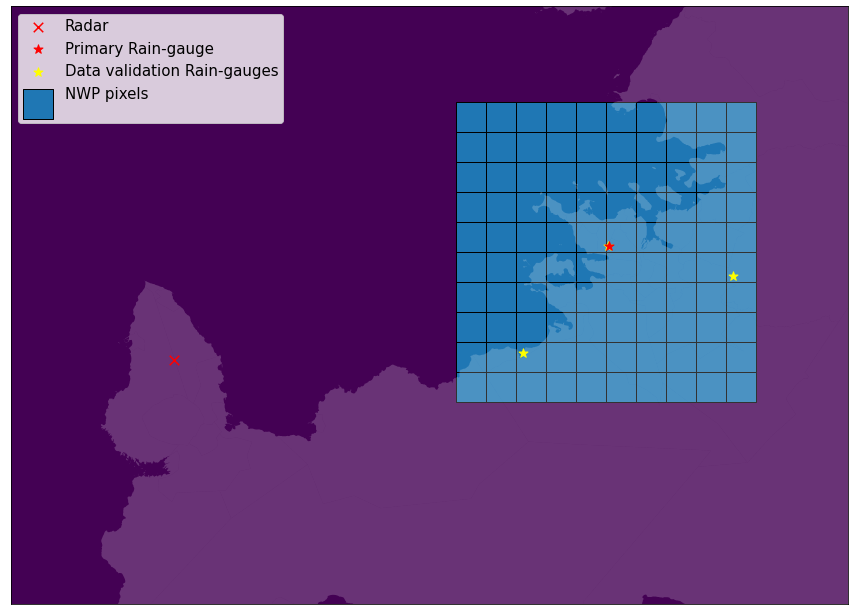

In [15]:

plt.figure(figsize=(15,15))
pixels_handle = plt.scatter(coords_x,coords_y,s = 900,marker = 's',edgecolors='black')
postnr.geometry.plot(ax = plt.gca(),alpha = 0.2,color='white')
radar_handle = plt.scatter(radar_x,radar_y,c ='red',marker = 'x',s = 90)

# show each gauge on the map
pixel_idx = []
for index,row in df_meta_gauge.iterrows():
    gauge_x,gauge_y = transformer_gps_isl.transform(row['x'],-row['y'])
    gauge_handle_extra = plt.scatter(gauge_x,gauge_y,c ='yellow',marker = '*',s = 90)

gauge_handle = plt.scatter(main_gauge_x,main_gauge_y,c ='red',marker = '*',s = 90)

plt.ylim(main_gauge_y - 30_000,main_gauge_y + 20_000)
plt.xlim(main_gauge_x - 50_000,main_gauge_x + 20_000)
plt.xticks([],[])
plt.yticks([],[])
plt.gca().set_facecolor((0.267004, 0.004874, 0.329415, 1.0))
# plt.title('Data overview - NWP',fontsize=25)
plt.legend([radar_handle,gauge_handle,gauge_handle_extra,pixels_handle],
           ['Radar','Primary Rain-gauge','Data validation Rain-gauges','NWP pixels\n'],
           loc = 'upper left',
           fontsize=15,
           borderpad=0.3)
plt.rcParams.update({'legend.labelspacing':0.25})
plt.show()

# plot the validation pixels

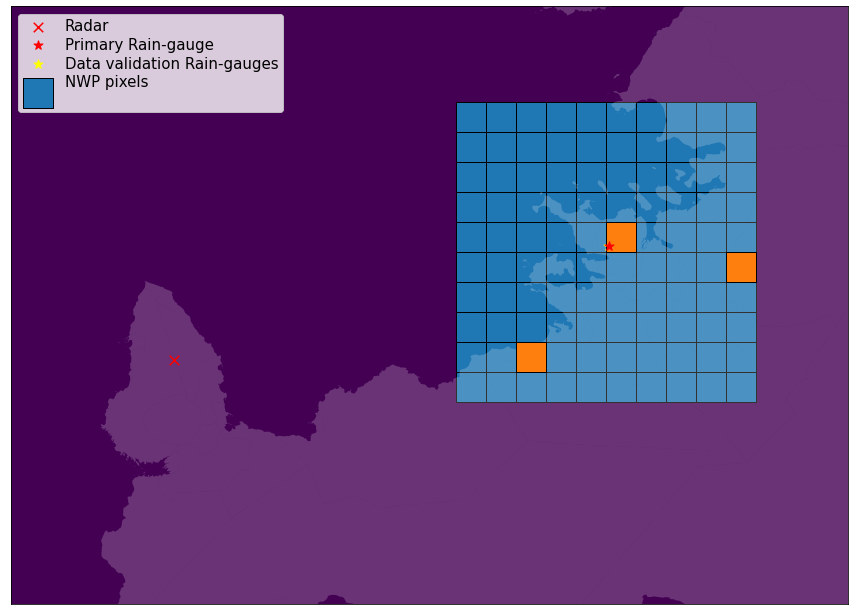

In [18]:
import matplotlib.patheffects as PathEffects


plt.figure(figsize=(15,15))
pixels_handle = plt.scatter(coords_x,coords_y,s = 900,marker = 's',edgecolors='black')
postnr.geometry.plot(ax = plt.gca(),alpha = 0.2,color='white')
radar_handle = plt.scatter(radar_x,radar_y,c ='red',marker = 'x',s = 90)

# Find closest pixel to each gauge (2d coordinates)
pixel_idx = []
for index,row in df_meta_gauge.iterrows():
    gauge_x,gauge_y = transformer_gps_isl.transform(row['x'],-row['y'])
    gauge_handle_extra = plt.scatter(gauge_x,gauge_y,c ='yellow',marker = '*',s = 90)
    gauge_idx,gauge_idy = get_idx_from_coords(coords,gauge_x,gauge_y)
    pixel_idx.append((gauge_idx,gauge_idy))
pixel_idx = np.array(pixel_idx)

# Translate those coordinates into coordinates within the 10x10 grid
## 1. Find the coordinates on the global list flattened
global_coordinates_flat = NWP_index[pixel_idx[:,0],pixel_idx[:,1]]

## 1. Get the coordinates of these points from within the 10x10 grid
gauge_coords_10x10_NWP = []
for g_coords in global_coordinates_flat:
    x_tmp,y_tmp = np.argwhere(NWP_idx.reshape(10,10) == g_coords)[0]
    gauge_coords_10x10_NWP.append((x_tmp,y_tmp))
    x_coords_from_10x10_coords_list = coords_x.reshape(10,10)[x_tmp,y_tmp]
    y_coords_from_10x10_coords_list = coords_y.reshape(10,10)[x_tmp,y_tmp]
    # plt.scatter(gauge_x,gauge_y,c ='yellow',marker = '*',s = 90)
    plt.scatter(x_coords_from_10x10_coords_list,y_coords_from_10x10_coords_list,s = 900,marker = 's',edgecolors='black',color='#ff7f0e')
    
gauge_handle = plt.scatter(main_gauge_x,main_gauge_y,c ='red',marker = '*',s = 90)

plt.ylim(main_gauge_y - 30_000,main_gauge_y + 20_000)
plt.xlim(main_gauge_x - 50_000,main_gauge_x + 20_000)
plt.xticks([],[])
plt.yticks([],[])
plt.gca().set_facecolor((0.267004, 0.004874, 0.329415, 1.0))
# plt.title('Data overview - NWP',fontsize=25)
plt.legend([radar_handle,gauge_handle,gauge_handle_extra,pixels_handle],
           ['Radar','Primary Rain-gauge','Data validation Rain-gauges','NWP pixels\n'],
           loc = 'upper left',
           fontsize=15,
           borderpad=0.3)
plt.rcParams.update({'legend.labelspacing':0.25})
plt.show()

In [19]:
from sklearn.metrics import r2_score,mean_squared_error

periods = [
    (datetime.datetime(2015,1,1),datetime.datetime(2019,12,31))
]

metrics = [('MSE',lambda x1,x2 : mean_squared_error(x1,x2)),
           ('correlation',lambda x1,x2 : np.corrcoef(x1,x2)[0,1]),
        #    ('R2',lambda x1,x2 : r2_score(x1,x2))
           ]

sensors = [('1475_R_manual','1475'),
           ('1473_R_manual','1473'),
           ('1481_R_raw','1481')]

In [25]:
ID_to_time_series_name

{1481: '1481_R_raw', 1475: '1475_R_manual', 1473: '1473_R_manual'}

In [40]:
gauge_list = [1481, 1475, 1473]

rel_coords_dict = {g:c for c,g in zip(gauge_coords_10x10_NWP, gauge_list)}
ID_to_time_series_name = {a:b for a,b in zip(gauge_list,['1481_R_raw','1475_R_manual','1473_R_manual'])}



gauge_id = 1475
colors = []
corrs_list = []
mse_profiles = []
for gauge_id in gauge_list:
    # gauge_id = 1473
    # gauge_id = 1481
    time_series_name = ID_to_time_series_name[gauge_id]
    rel_coords = rel_coords_dict[gauge_id]
    rel_coords_df = pd.DataFrame(nwp_data.values.reshape(-1,66,10,10)[:,:,rel_coords[0],rel_coords[1]],index = nwp_data.index)

    x_gau = df_gauge.loc[d_start:d_end,['1481_R_raw','1475_R_manual','1473_R_manual']]
    x_gau_nogaps = x_gau.loc[d_start:d_end].resample('1h').mean()

    y_trues = []
    y_preds = []
    
    for time_start in rel_coords_df.index:
        y_true = x_gau_nogaps.loc[time_start:time_start + datetime.timedelta(hours=60),time_series_name].values.ravel()
        y_pred = rel_coords_df.loc[time_start,:60].values.ravel()
        
        if np.isnan(y_true).any() or np.isnan(y_pred).any():
            # print('hey')
            continue
        if (len(y_true) != 61) or (len(y_pred) == 0):
            # print('hey')
            continue
            
        y_trues.append(y_true)
        y_preds.append(y_pred)
        # plt.plot(y_true)
        # plt.plot(y_pred)
        # plt.legend(['gauge','NWP'])
    y_trues = np.array(y_trues)
    y_preds = np.array(y_preds)
    
    corrs = []
    for y1,y2 in zip(y_trues.T,y_preds.T):
        corr = np.corrcoef(y1,y2)[0,1]      
        corrs.append(corr)
        

    corrs_list.append(corrs)
    resids = y_trues - y_preds    
    
    mse_profile = np.mean(resids**2,axis=0)
    mse_profiles.append(mse_profile)

    
    
label_fontsize = 15
title_fontsize = 20


mse_profiles_NWP = np.array(mse_profiles)
corrs_list_NWP = np.array(corrs_list)


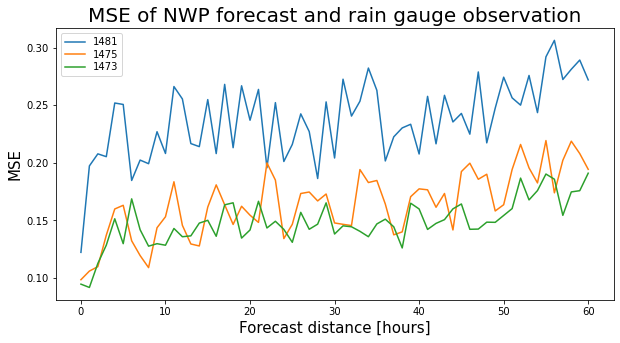

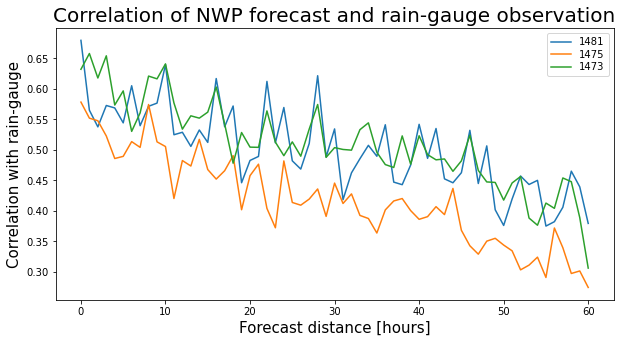

In [44]:

plt.figure(figsize=(10,5))
plt.plot(mse_profiles_NWP.T,label = str(gauge_id) + ' NWP')
plt.ylabel('MSE',fontsize = label_fontsize)
plt.xlabel('Forecast distance [hours]',fontsize = label_fontsize)
plt.title('MSE of NWP forecast and rain gauge observation',fontsize= title_fontsize)
plt.legend(gauge_list)
plt.show()


plt.figure(figsize=(10,5))
plt.plot(corrs_list_NWP.T)
plt.xlabel('Forecast distance [hours]',fontsize = label_fontsize)
plt.ylabel('Correlation with rain-gauge',fontsize = label_fontsize)
plt.legend(gauge_list)
plt.title('Correlation of NWP forecast and rain-gauge observation',fontsize= title_fontsize)
plt.show()


# Persistence

In [45]:
gauge_list = [1481, 1475, 1473]

rel_coords_dict = {g:c for c,g in zip(gauge_coords_10x10_NWP, gauge_list)}
ID_to_time_series_name = {a:b for a,b in zip(gauge_list,['1481_R_raw','1475_R_manual','1473_R_manual'])}


colors = []
corrs_list = []
mse_profiles = []
for gauge_id in gauge_list:
    # gauge_id = 1473
    # gauge_id = 1481
    time_series_name = ID_to_time_series_name[gauge_id]
    rel_coords = rel_coords_dict[gauge_id]
    rel_coords_df = pd.DataFrame(nwp_data.values.reshape(-1,66,10,10)[:,:,rel_coords[0],rel_coords[1]],index = nwp_data.index)

    x_gau = df_gauge.loc[d_start:d_end,['1481_R_raw','1475_R_manual','1473_R_manual']]
    x_gau_nogaps = x_gau.loc[d_start:d_end].resample('1h').mean()

    y_trues = []
    y_preds = []
    
    for time_start in rel_coords_df.index:
        y_true = x_gau_nogaps.loc[time_start:time_start + datetime.timedelta(hours=60),time_series_name].values.ravel()
        y_pred = rel_coords_df.loc[time_start,:60].values.ravel()
        if np.isnan(y_true).any() or np.isnan(y_pred).any():
            # print('hey')
            continue
        if (len(y_true) != 61) or (len(y_pred) == 0):
            # print('hey')
            continue
            
        y_pred[:] = y_true[0]
        y_trues.append(y_true)
        y_preds.append(y_pred)
        # plt.plot(y_true)
        # plt.plot(y_pred)
        # plt.legend(['gauge','NWP'])
    y_trues = np.array(y_trues)
    y_preds = np.array(y_preds)
    
    corrs = []
    for y1,y2 in zip(y_trues.T,y_preds.T):
        corr = np.corrcoef(y1,y2)[0,1]      
        corrs.append(corr)
    corrs_list.append(corrs)
    resids = y_trues - y_preds
    
    mse_profile = np.mean(resids**2,axis=0)
    mse_profiles.append(mse_profile)
    # tmp_handle = plt.plot(mse_profile,label = str(gauge_id) + ' NWP')
    # c = tmp_handle[0].get_color()
    # colors.append(c)
    
mse_profiles_persistense = np.array(mse_profiles)
corrs_list_persistence = np.array(corrs_list)

label_fontsize = 15
title_fontsize = 20


1473

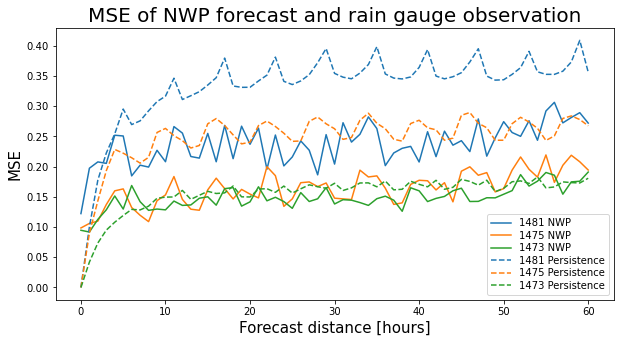

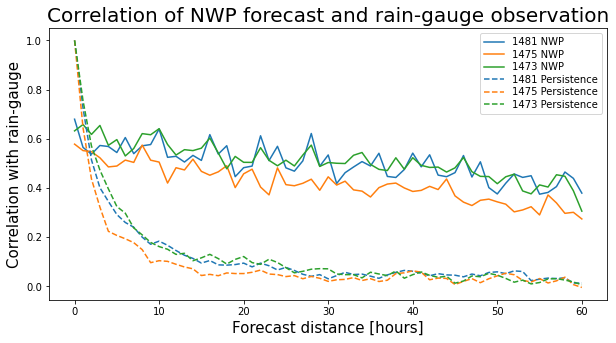

In [64]:

plt.figure(figsize=(10,5))

NWP_MSE_handles = plt.plot(mse_profiles_NWP.T,label = [str(i) + ' NWP' for i in gauge_list])
colors = [NWP_MSE_handles[i].get_color() for i in range(3)]
for c,p,name in zip(colors,mse_profiles_persistense,gauge_list):
    plt.plot(p,label = str(name) + ' Persistence',c=c,linestyle = '--')
    
    
plt.ylabel('MSE',fontsize = label_fontsize)
plt.xlabel('Forecast distance [hours]',fontsize = label_fontsize)
plt.title('MSE of NWP forecast and rain gauge observation',fontsize= title_fontsize)
plt.legend()
plt.show()



plt.figure(figsize=(10,5))
NWP_corr_handles = plt.plot(corrs_list_NWP.T,label = [str(i) + ' NWP' for i in gauge_list])

colors = [NWP_corr_handles[i].get_color() for i in range(3)]
for c,p,name in zip(colors,corrs_list_persistence,gauge_list):
    plt.plot(p,label = str(name) + ' Persistence',c=c,linestyle = '--')
    
plt.xlabel('Forecast distance [hours]',fontsize = label_fontsize)
plt.ylabel('Correlation with rain-gauge',fontsize = label_fontsize)
plt.title('Correlation of NWP forecast and rain-gauge observation',fontsize= title_fontsize)
plt.legend()
plt.show()


# Together

In [459]:
# plt.figure(figsize=(25,5))
# plt.plot(y_trues[:,0])
# plt.plot(y_preds[:,0])


# plt.figure(figsize=(25,5))
# plt.plot(y_trues[:,24])
# plt.plot(y_preds[:,24])


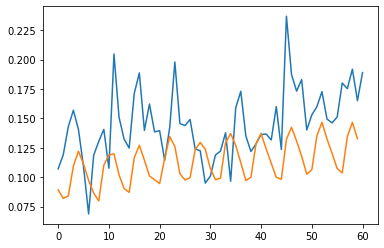

In [491]:
resids = y_trues - y_preds
resids = y_trues - np.roll(np.roll(y_preds,0,axis=0),0,axis=1)
mse_profile = np.mean(resids**2,axis=0)
plt.plot(mse_profile)
plt.plot(mses)


# Just for fun  (Seeing how much bias correction does)

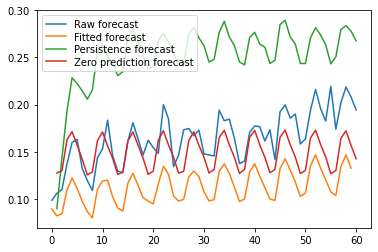

In [463]:
from sklearn.linear_model import LinearRegression
mses = []
for i in range(60):
    reg = LinearRegression()
    reg.fit(y_preds[:,[i]],y_trues[:,[i]])
    # print(reg.coef_)
    y_preds_corrected = reg.predict(y_preds[:,[i]])
    # print(y_preds_corrected.shape)
    # print(y_trues[:,i].shape)
    resids = y_trues[:,i].ravel() - y_preds_corrected.ravel()
    
    # resids = y_trues - np.roll(np.roll(y_preds,0,axis=0),0,axis=1)
    mse_profile = np.mean(resids**2,axis=0)
    mses.append(mse_profile)
    

resids = y_trues - y_preds
resids = y_trues - np.roll(np.roll(y_preds,0,axis=0),0,axis=1)
mse_profile = np.mean(resids**2,axis=0)
plt.plot(mse_profile)
plt.plot(mses)

resids_persist = y_trues - y_trues[:,[0]]
mse_profile_persist = np.mean(resids_persist**2,axis=0)
plt.plot(range(1,len(mse_profile_persist)),mse_profile_persist[1:])


resids_pred_zero= y_trues - 0
mse_profile_pred_zero== np.mean(resids_pred_zero**2,axis=0)
plt.plot(range(1,len(mse_profile_pred_zero)),mse_profile_pred_zero[1:])

plt.legend(['Raw forecast','Fitted forecast','Persistence forecast','Zero prediction forecast'])

In [435]:
# range(1,len(mse_profile_persist[1:])),mse_profile_persist[1:].shape
len(range(1,len(mse_profile_persist[1:]))),mse_profile_persist[1:].shape

(59, (60,))

In [40]:
from scipy.optimize import minimize
results_list = {}
for p1,p2 in periods:
    for s1,s2 in sensors:
        # compute optimal w.r.t. MSE
        # min_results_1_25km = minimize(lambda x : get_mse(x,s1,s2,p1,p2,df_radar_1_subset_dirty_interpolation),
        #                               (200,1.6),
        #                             #   bounds = [(200,600),(1.5,2)]
        #                               )

        # a_1_25,b_1_25 = min_results_1_25km.x
        # a_2,b_2  = min_results_2km.x
        # # a_1_25,b_1_25 = 200,2
        # # a_2,b_2  = 200,2
        # print(p1,s2)
        # print(a_1_25,b_1_25)
        # print(a_2,b_2)
        
        x_gau = df_gauge.loc[p1:p2,s1]

        common_index_1 = x_rad_R1o.dropna().index.intersection(x_gau.dropna().index)
        common_index_2 = x_rad_R2o.dropna().index.intersection(x_gau.dropna().index)
        
        for metric_name,metric in metrics:
            # print(p1,p2,metric_name,s1)
            results_list[(p1.strftime('%b-%Y'),p2.strftime('%b-%Y'),metric_name,s1,'a=200,b=1.6','2km')] = metric(x_rad_R1d.loc[common_index_1],x_gau.loc[common_index_1])
            results_list[(p1.strftime('%b-%Y'),p2.strftime('%b-%Y'),metric_name,s1,f'a={a_1_25},b={b_1_25}','2km')] = metric(x_rad_R1o.loc[common_index_1],x_gau.loc[common_index_1])
            results_list[(p1.strftime('%b-%Y'),p2.strftime('%b-%Y'),metric_name,s1,'a=200,b=1.6','1.25km')] = metric(x_rad_R2d.loc[common_index_2],x_gau.loc[common_index_2])
            results_list[(p1.strftime('%b-%Y'),p2.strftime('%b-%Y'),metric_name,s1,f'a={a_1_25},b={b_1_25}','1.25km')] = metric(x_rad_R2o.loc[common_index_2],x_gau.loc[common_index_2])
            

NameError: name 'df_radar_1_subset_dirty_interpolation' is not defined